# Unlearning Experiments ([steps](https://www.overleaf.com/project/623aa8d6b133433e9006bc8a))

In [42]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import random
from google.colab import files
files.upload()

# Define 3-layer fully connected neural network
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

Saving model_reg_seed_0.pt to model_reg_seed_0 (1).pt
Saving model_reg_seed_1.pt to model_reg_seed_1 (1).pt
Saving model_removed_0_seed_0.pt to model_removed_0_seed_0 (1).pt
Saving model_removed_0_seed_1.pt to model_removed_0_seed_1 (1).pt
Saving model_removed_1_seed_0.pt to model_removed_1_seed_0 (1).pt
Saving model_removed_1_seed_1.pt to model_removed_1_seed_1 (1).pt
Saving model_removed_2_seed_0.pt to model_removed_2_seed_0 (1).pt
Saving model_removed_2_seed_1.pt to model_removed_2_seed_1 (1).pt
Saving model_removed_3_seed_0.pt to model_removed_3_seed_0 (1).pt
Saving model_removed_3_seed_1.pt to model_removed_3_seed_1 (1).pt
Saving model_removed_4_seed_0.pt to model_removed_4_seed_0 (1).pt
Saving model_removed_4_seed_1.pt to model_removed_4_seed_1 (1).pt
Saving model_removed_5_seed_0.pt to model_removed_5_seed_0 (1).pt
Saving model_removed_5_seed_1.pt to model_removed_5_seed_1 (1).pt
Saving model_removed_6_seed_0.pt to model_removed_6_seed_0 (1).pt
Saving model_removed_6_seed_1.pt t

In [52]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

# Prints and returns the accuracy and average loss for the test set.
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct * 100

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

batch_size = 100
loss_fn = nn.CrossEntropyLoss()
test_dataloader = DataLoader(test_data, batch_size=batch_size)

cpu


In [44]:
# models[i][0] will be the regular model for the i'th seed, models[i][1][k] will
# be the modified model for the i'th seed with an element from class j removed
models = []

for seed in range(2):
    models_for_seed = []

    # Load the regular model
    model_reg_state_dict = torch.load("model_reg_seed_" + str(seed) + ".pt", map_location=torch.device('cpu'))
    model_reg = NeuralNetwork()
    model_reg.load_state_dict(model_reg_state_dict)
    models_for_seed.append(model_reg)

    # Load the modified models
    modified_models = []
    for label in range(10):
        filename = "model_removed_" + str(label) + "_seed_" + str(seed) + ".pt"
        model_modified_state_dict = torch.load(filename, map_location=torch.device('cpu'))
        model_modified = NeuralNetwork()
        model_modified.load_state_dict(model_modified_state_dict)
        modified_models.append(model_modified)
    
    models_for_seed.append(modified_models)
    models.append(models_for_seed)


In [45]:
# Flatten the model weights to a single vector.

# Applies a function to each element of a nested list
def apply(item, fun):
    if isinstance(item, list):
        return [apply(x, fun) for x in item]
    else:
        return fun(item)

# Return a 1D representation of all the weights in the model.
def get_weights(model):
    weights = []
    for _, param in model.named_parameters():
        weights.append(param.data.flatten())
    return torch.concat(weights)

model_weights = apply(models.copy(), get_weights)

669706


In [46]:
# Compute the d_1(U) values
d_values = []
for seed in range(2):
    values_for_seed = []
    for label in range(10):
        difference = model_weights[seed][0] - model_weights[seed][1][label]
        values_for_seed.append(torch.norm(difference, 2))
    d_values.append(values_for_seed)
d_values

[[tensor(0.5699),
  tensor(0.6787),
  tensor(0.6735),
  tensor(0.6040),
  tensor(0.6153),
  tensor(0.5854),
  tensor(0.6899),
  tensor(0.6346),
  tensor(0.6102),
  tensor(0.6388)],
 [tensor(0.6361),
  tensor(0.6521),
  tensor(0.5930),
  tensor(0.7998),
  tensor(0.5401),
  tensor(0.6229),
  tensor(0.9102),
  tensor(0.6549),
  tensor(0.6492),
  tensor(0.8099)]]

In [47]:
# Save model params before adding noise
saved_model_params = apply(models.copy(), lambda x : x.state_dict())

In [ ]:
# Compute test error for w(S) models and w(S\U) models for fixed epsilon/delta.
import numpy as np

epsilon = 2 
delta = 0.1

def compute_all_losses(models, saved_model_params, epsilon, delta, loss_fn = loss_fn, test_dataloader = test_dataloader):
    # Compute standard deviation of Gaussain noise to add to each model
    c = np.sqrt(2 * np.log(1.25/delta))
    sigma_divided_by_d = c / epsilon

    with torch.no_grad():
        accuracies = []
        for seed in range(2):
            print("Seed: " + str(seed))
            print("Regular test error (without removing an element or adding noise)")
            test(test_dataloader, models[seed][0], loss_fn)

            for label in range(10):
                np.random.seed(0)
                print("Seed: " + str(seed))
                print("Delete requests U is an element from class: " + str(label))
                model = NeuralNetwork()
                model.load_state_dict(saved_model_params[seed][1][label])
                # Add noise to w(S \ U)
                for param in model.parameters():           
                    sigma = sigma_divided_by_d * d_values[seed][label]
                    param.add_(np.random.normal(0, sigma))
                accuracies.append(test(test_dataloader, model, loss_fn))
    return accuracies

Seed: 0
Regular test error (without removing an element or adding noise)
Test Error: 
 Accuracy: 88.7%, Avg loss: 0.324008 

Seed: 0
Delete requests U is an element from class: 0
Test Error: 
 Accuracy: 10.0%, Avg loss: 375540.682188 

Seed: 0
Delete requests U is an element from class: 1
Test Error: 
 Accuracy: 10.0%, Avg loss: 530560.034062 

Seed: 0
Delete requests U is an element from class: 2
Test Error: 
 Accuracy: 10.0%, Avg loss: 524661.785312 

Seed: 0
Delete requests U is an element from class: 3
Test Error: 
 Accuracy: 10.0%, Avg loss: 423025.587500 

Seed: 0
Delete requests U is an element from class: 4
Test Error: 
 Accuracy: 10.0%, Avg loss: 435495.921875 

Seed: 0
Delete requests U is an element from class: 5
Test Error: 
 Accuracy: 10.0%, Avg loss: 391227.314063 

Seed: 0
Delete requests U is an element from class: 6
Test Error: 
 Accuracy: 10.0%, Avg loss: 546975.242188 

Seed: 0
Delete requests U is an element from class: 7
Test Error: 
 Accuracy: 10.0%, Avg loss: 465

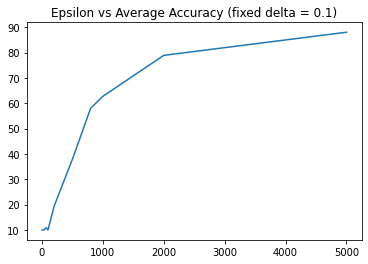

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt

epsilon_vals = [2, 10, 30, 50, 70, 100, 200, 500, 800, 1000, 2000, 5000]
accuracies = []

for epsilon in epsilon_vals:
    accuracies.append(np.mean(compute_all_losses(models, saved_model_params, epsilon, delta)))

sns.lineplot(x = epsilon_vals, y = accuracies)
plt.title("Epsilon vs Average Accuracy (fixed delta = 0.1)")
plt.show()